# Imports

In [1]:
#load txt files as csv into numpy arrays
import numpy as np
import kaleido #required
kaleido.__version__ #0.2.1

import plotly
plotly.__version__ #5.5.0

#now this works:
import plotly.graph_objects as go
from scipy.signal import find_peaks
import os
from os.path import isfile, join
import pandas as pd

# ROI extraction code (translated from Matlab/Chinese)

In [5]:
import numpy as np
from scipy.fft import fftn, ifftn, fftshift
from skimage.registration import phase_cross_correlation

def compute_translation(frame1, frame2, upsample_factor=1000):
    # Ensure inputs are float64 for high precision
    frame1 = frame1.astype(np.float64)
    frame2 = frame2.astype(np.float64)

    # Compute the cross-power spectrum
    product = fftn(frame1) * np.conj(fftn(frame2))
    cross_power_spectrum = product / np.abs(product)

    # Inverse FFT to find the correlation
    corr = fftshift(np.abs(ifftn(cross_power_spectrum)))

    # Find the peak in the correlation
    max_corr = np.unravel_index(np.argmax(corr), corr.shape)
    shifts = np.array(max_corr) - np.array(frame1.shape) / 2

    # Subpixel refinement using upsampled phase cross-correlation
    if upsample_factor > 1:
        refined_shifts, error, diffphase = phase_cross_correlation(
            frame1, frame2, upsample_factor=upsample_factor
        )
        return refined_shifts[::-1]  # Match MATLAB's x-y order

    return shifts[::-1]  # Match MATLAB's x-y order

In [2]:
import numpy as np
import cv2
from scipy.signal import butter, filtfilt, medfilt2d, correlate
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from sklearn.decomposition import NMF
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import imregpoc

# Set random seed for reproducibility
np.random.seed(42)

# Butterworth filter coefficients
b1, a1 = butter(4, 0.02)
b2, a2 = butter(4, 0.08, btype='high')

T = 18000  # Total number of frames
T2 = 2250  # Downsampled frames

# Read and align the video frames
IM = np.zeros((128, 128, T), dtype=np.float32)
cap = cv2.VideoCapture('data/CTZ2.avi')

i = 0
ret = True

while ret:
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frame = gray_frame.astype(np.float64)
    if i == 0:
        IM[:, :, i] = gray_frame
        prev_frame = gray_frame
    else:
        result = imregpoc.imregpoc(prev_frame,gray_frame)
        transform = result.getPerspective()


        # Apply the calculated shift to the current frame
        # aligned_frame = shift(gray_frame, shift=(-shift_yx[0], -shift_yx[1]), order=1)

        # Store the aligned frame
        IM[:, :, i] = aligned_frame
        prev_frame = aligned_frame
    i += 1
cap.release()

# while ret:
#     ret, frame = cap.read()
#     if not ret:
#             break
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if ret else None
#     if i == 0:
#         IM[:, :, i] = gray_frame
#         prev_frame = gray_frame
#     else:
#         # ECC-based image alignment
#         warp_matrix = np.eye(2, 3, dtype=np.float32)  # Identity matrix for affine transformation
#         try:
#             criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 1e-5)
#             _, warp_matrix = cv2.findTransformECC(
#                 prev_frame, gray_frame, warp_matrix, cv2.MOTION_AFFINE, criteria)
#             aligned_frame = cv2.warpAffine(
#                 gray_frame, warp_matrix, (128, 128), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
#             IM[:, :, i] = aligned_frame
#             prev_frame = aligned_frame
#         except cv2.error as e:
#             print(f"Warning: Alignment failed at frame {i}. Using unaligned frame.")
#             IM[:, :, i] = gray_frame
#             prev_frame = gray_frame
#     i += 1

cap.release()


# Downsample IM to create IMds
IMds = IM.astype(np.float32)
for _ in range(3):
    IMds = (IMds[:, :, ::2] + IMds[:, :, 1::2]) / 2

# Compute F0 and dF0
IM = IM.astype(np.float32)
IMds = IMds.astype(np.float32)
e1 = median_filter(IMds.reshape(-1, IMds.shape[2]), size=(1, 3), mode='reflect')
v, a = 0, 0.04
for t in range(1, e1.shape[1]):
    e1[:, t] = np.minimum(e1[:, t], e1[:, t - 1] + v + a)
    v = np.maximum(0, e1[:, t] - e1[:, t - 1])

F0ds = filtfilt(b1, a1, e1, axis=1)
for _ in range(6):
    delta = np.minimum(0, e1 - F0ds)
    delta[:, :20] = 0
    delta[:, -20:] = 0
    F0ds = filtfilt(b1, a1, F0ds + 2 * delta, axis=1)
F0ds = F0ds.reshape(128, 128, T2)

# Interpolation
reshaped_F0ds = F0ds.reshape(128 * 128, T2)
xq = np.arange(1, T + 1)
x = np.linspace(1, T, T2)
F0_interp = np.zeros((128 * 128, T))
for idx in range(128 * 128):
    interp_func = interp1d(x, reshaped_F0ds[idx, :], kind='linear', fill_value='extrapolate')
    F0_interp[idx, :] = interp_func(xq)
F0 = F0_interp.reshape(128, 128, T)

# Calculate dF
dF = IM - F0

# Downsampled dF calculation
dFds = IMds - F0ds
dFdshp = np.transpose(filtfilt(b2, a2, np.transpose(dFds, (2, 0, 1)), axis=0), (1, 2, 0))

# Correlation Image Calculation
ss = np.sum(dFdshp**2, axis=2)
vertC = np.sum(dFdshp * np.roll(dFdshp, shift=1, axis=0), axis=2) / np.sqrt(ss * np.roll(ss, shift=1, axis=0))
horzC = np.sum(dFdshp * np.roll(dFdshp, shift=1, axis=1), axis=2) / np.sqrt(ss * np.roll(ss, shift=1, axis=1))
C = np.nanmean(np.stack([horzC, np.roll(horzC, 1, axis=1), vertC, np.roll(vertC, 1, axis=0)]), axis=0)

# Detect peaks in correlation image
sigma = 2
bgFrac = 0.2
maxN = 600
C = gaussian_filter(C, 0.5)
C2 = np.copy(C)
Cthresh = 2 * (np.median(C) - np.percentile(C, 1))
C2[C2 < (np.median(C) + Cthresh)] = 0
BW = peak_local_max(C2, min_distance=6, threshold_abs=0)
Pr, Pc = BW[:, 0], BW[:, 1]
nComp = len(BW)

# Initialize W0
sz = (128, 128)
W0 = np.zeros((np.prod(sz), nComp))
for idx, (r, c) in enumerate(BW):
    W0[r * sz[1] + c, idx] = 1

W0 = gaussian_filter(W0.reshape(*sz, nComp), sigma=(0.5, 0.5, 0)).reshape(-1, nComp)

# Non-negative Matrix Factorization (NMF)
model = NMF(n_components=nComp, init='custom', max_iter=20)
H0 = model.fit_transform(dFds.reshape(-1, T2), W=W0)
W0 = model.components_

# Compute full speed data Hhf
dF_flat = dF.reshape(-1, T)
Hhf = np.linalg.lstsq(W0.T, dF_flat.T, rcond=None)[0].T

# Saving results to .txt files
np.savetxt('W0.txt', W0, fmt='%.6f')
np.savetxt('Hhf.txt', Hhf, fmt='%.6f')
np.savetxt('F0.txt', F0.reshape(-1, T), fmt='%.6f')
np.savetxt('dF.txt', dF.reshape(-1, T), fmt='%.6f')

print("Data saved to text files.")


Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 519, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_frame.py", line 948, in trace_dispatch
    self.do_wait_suspend(thread, frame, event, arg)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_frame.py", line 164, in do_wait_suspend
    self._args[0].do_wait_suspend(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2023, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "

KeyboardInterrupt: 

# Helper functions

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, delimiter='\t')
    #Remove columns that have NANs
    df = df.dropna(axis=1)
    #Convert to numpy array
    array = df.to_numpy()

    #Remove first column (time) if it is in the dataframe
    if 'Time' in df.columns:
        array = array[:, 1:]

    return array, df


def compute_firing_frequency(peaks, num_samples, sampling_rate):
    """
    Compute the firing frequency (peaks per second) based on identified peaks.
    
    Parameters:
    - peaks: array-like, indices of the detected peaks.
    - num_samples: int, total number of samples in the recording.
    - sampling_rate: int, number of samples per second (e.g., 100).
    
    Returns:
    - firing_frequency: list, firing frequency (peaks per second) for each second.
    """
    # Calculate the total recording time in seconds
    total_seconds = num_samples // sampling_rate
    
    # Initialize a list to hold the firing frequency for each second
    firing_frequency = []
    
    # Loop through each second and count the number of peaks in that interval
    for sec in range(total_seconds):
        start_idx = sec * sampling_rate  # Start of the second in samples
        end_idx = (sec + 1) * sampling_rate  # End of the second in samples
        peaks_in_second = len([peak for peak in peaks if peak >= start_idx and peak < end_idx])
        
        firing_frequency.append(peaks_in_second)
    
    return firing_frequency


# Define rolling window smoothing function
def rolling_window_smooth(signal, window_size):
    """Apply rolling window smoothing using a simple moving average."""
    window = np.ones(window_size) / window_size  # Create a uniform window
    smoothed_signal = np.convolve(signal, window, mode='same')  # Apply smoothing
    return smoothed_signal


def precise_peak_locs(smoothed_peaks, trace, median_val):
    heights = []
    peaks = []
    for peak in smoothed_peaks:
        #smoothed peak location might not the actual peak due to smoothing
        #Get the position within original trace corresponding to the largest value in the window
        true_peak = np.argmax(trace[peak-15:peak+15]) + peak - 15 #Due to smoothing the peak is shifted to the right
        peaks.append(true_peak)
        absolute_height = trace[true_peak]
        real_height = absolute_height - median_val
        heights.append([absolute_height, real_height])
    return peaks, heights


def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def peak_finder(trace):
    window_size = 15  # To be adjusted if needed
    smoothed_trace = rolling_window_smooth(trace, window_size)
    #remove the edges
    smoothed_trace = smoothed_trace[window_size:-window_size]
    smoothed_trace = np.pad(smoothed_trace, (window_size, window_size), 'constant', constant_values=(1, 1))

    #calculate 50th percentile
    percentile = np.percentile(smoothed_trace, 50)
    below_percentile = smoothed_trace[smoothed_trace < percentile]
    below_percentile_std = np.std(below_percentile)
    median_val = np.median(below_percentile)
    # mad = np.median(np.abs(smoothed_trace - median_val)) * 1.4826
    height_threshold = median_val + 9 * below_percentile_std
    prominence_threshold = 8 * below_percentile_std

    # median_val = np.median(smoothed_trace)
    # mad = np.median(np.abs(smoothed_trace - median_val)) * 1.4826
    # height_threshold = median_val + 3 * mad
    # prominence_threshold = 6 * mad
    width_threshold = 10 #Empirically determined
    smoothed_peaks, _ = find_peaks(smoothed_trace, height=height_threshold, prominence=prominence_threshold, width=width_threshold)
    peaks, heights = precise_peak_locs(smoothed_peaks, trace, median_val)
    
    return peaks, np.array(heights), height_threshold, smoothed_trace


def plot_peaks(roi, trace, smoothed_trace, peaks, peak_heights, height_threshold, data_output_dir):
    x_arr = np.arange(trace.shape[0]) / 100
    fig = go.Figure()
    #Set figure size
    fig.update_layout(width=1000, height=600)
    fig.add_trace(go.Scatter(x=x_arr, y=trace, name=roi))
    #check if the 0th peak is a None
    if peaks[0] is not None:
        fig.add_trace(go.Scatter(x=[p/100 for p in peaks], y=trace[peaks], mode='markers', name='Peaks'))
    fig.add_trace(go.Scatter(x=x_arr, y=smoothed_trace, name='Smoothed Trace'))
    fig.add_hline(y=height_threshold, line_dash='dash', line_color='gray', annotation_text='Threshold', annotation_position='top right')

    #Now do the same for dark background
    fig.update_layout(template='plotly_dark')
    fig.update_layout(xaxis_title='Time [s]', yaxis_title='Intensity [dF/F]', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    

    #Add peak heights (from properties) next to the peaks
    # for i, peak in enumerate(peaks):
    #     fig.add_annotation(x=peak, y=trace[peak], text=f'{peak_heights[i]:.2f}', showarrow=False)
    
    output_file_root = os.path.join(data_output_dir, roi + '_peaks')
    #Save the plot as html
    fig.write_html(output_file_root + '.html') 
    #Save the plot as pdf
    fig.write_image(output_file_root + '.pdf', format='pdf')


# Plot the firing frequency
def plot_firing_frequency(firing_freq_per_sec):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(len(firing_freq_per_sec)), y=firing_freq_per_sec))
    fig.update_layout(title='Firing Frequency per Second', xaxis_title='Second', yaxis_title='Firing Frequency')
    fig.show()


def calc_noise_levels(array, roi_id):
    #iterating over each roi, calculate the noise level, assuming baseline is at the 5th percentile
    trace = array[:, roi_id]
    percentile = np.percentile(trace, 50)
    below_percentile = trace[trace < percentile]
    below_percentile_std = np.std(below_percentile)
    return below_percentile_std


#plot noise level for each roi
def plot_noise_level(array):
    noise_levels = []
    for roi_id in range(array.shape[1]):
        noise_levels.append(calc_noise_levels(array, roi_id))
    #plot a line of best fit
    line = np.polyfit(np.arange(len(noise_levels)), noise_levels, 1)
    line_fn = np.poly1d(line)   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(len(noise_levels)), y=noise_levels, mode='markers', name='ROIs'))
    fig.add_trace(go.Scatter(x=np.arange(len(noise_levels)), y=line_fn(np.arange(len(noise_levels))), name='Line of Best Fit'))

    #Make the plot black
    fig.update_layout(template='plotly_dark')
    fig.update_layout(xaxis_title='ROI', yaxis_title='Median Absolute Deviation', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    fig.show()


def plot_noise_level_histogram(experiment_df, data_output_dir):
    #Plot a histogram of the noise levels using plotly
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=experiment_df['noise_level'], nbinsx=50))
    fig.update_layout(title='Noise Level Distribution', xaxis_title='Noise Level', yaxis_title='Count')
    #Makee the plot dark
    fig.update_layout(template='plotly_dark')
    #Save as html and as pdf
    fig.write_html('noise_level_histogram.html')

    output_file_root = os.path.join(data_output_dir, '_noise_level_histogram')
    #Save the plot as html
    fig.write_html(output_file_root + '.html') 
    #Save the plot as pdf
    fig.write_image(output_file_root + '.pdf', format='pdf')
    


def raw_signal_pearson(array):
    # Compute the Pearson correlation coefficient between each pair of ROIs
    corr_matrix = np.corrcoef(array, rowvar=False)
    # Plot correlation matrix using plotly
    fig = go.Figure(data=go.Heatmap(z=corr_matrix, colorscale='Viridis'))
    fig.update_layout(width=800, height=800)
    #make the plot dark
    fig.update_layout(template='plotly_dark')
    fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    #Add label to heat bar
    fig.update_layout(coloraxis_colorbar=dict(title='Pearson Correlation'))
    #Add labels to x and y axis
    fig.update_xaxes(title_text='ROI ID')
    fig.update_yaxes(title_text='ROI ID')
    fig.show()


def peak_event_cross_correlation(peaks, max_lag=15):
    """
    Calculate the cross-correlation for each pair of ROIs based on actual peak events only.

    Parameters:
    - peaks: numpy array of shape (N, T), where N is the number of ROIs and T is the number of timepoints.
             Values should be 0 (no peak) or 1 (peak).
    - max_lag: int, maximum lag in timepoints for assessing synchrony.

    Returns:
    - event_corrs: numpy array of shape (N, N, 2 * max_lag + 1) with cross-correlation based on peak events only.
    - lags: array of lags used in the cross-correlation.
    """
    N, T = peaks.shape
    lags = np.arange(-max_lag, max_lag + 1)
    event_corrs = np.zeros((N, N, 2 * max_lag + 1))
    
    for i in range(N):
        for j in range(N):
            for lag_index, lag in enumerate(lags):
                shifted_peaks_j = np.roll(peaks[j], lag)
                overlap_indices = np.where(peaks[i] * shifted_peaks_j == 1)[0]
                # Calculate coincidence rate
                if len(overlap_indices) > 0:
                    event_corrs[i, j, lag_index] = len(overlap_indices) / min(np.sum(peaks[i]), np.sum(peaks[j]))
                else:
                    event_corrs[i, j, lag_index] = 0

    return event_corrs, lags


def aggregate_event_cross_correlation(peaks, max_lag=15, aggregation='mean'):
    """
    Calculate and aggregate the event-based cross-correlation for all pairs of ROIs.

    Parameters:
    - peaks: numpy array of shape (N, T), where N is the number of ROIs and T is the number of timepoints.
             Values should be 0 (no peak) or 1 (peak).
    - max_lag: int, maximum lag for assessing synchrony.
    - aggregation: str, either 'mean' or 'max', specifying how to aggregate the correlations across lags.

    Returns:
    - aggregated_corr: numpy array of shape (N, N), representing the aggregated synchrony measure for each ROI pair.
    """
    # Calculate the event-based cross-correlation with the function from the previous step
    event_corrs, lags = peak_event_cross_correlation(peaks, max_lag=max_lag)

    # Aggregate the cross-correlation across lags
    if aggregation == 'mean':
        aggregated_corr = np.mean(event_corrs, axis=2)
    elif aggregation == 'max':
        aggregated_corr = np.max(event_corrs, axis=2)
    else:
        raise ValueError("Aggregation method must be either 'mean' or 'max'")
    
    return aggregated_corr


def peak_to_peak_distance(df, recordings_duration, data_output_dir, experiment_id):
    #calculate the average peak-to-peak distance for each ROI (each time sample is 1ms)
    peak_to_peak_dists_columnames = ['roi_id', 'mean_peak_to_peak_distance[ms]', 'mean_firing_frequency[Hz]']
    peak_to_peak_dists = pd.DataFrame(columns=peak_to_peak_dists_columnames)
    for roi in df['roi_id'].unique():
        roi_df = df[df['roi_id'] == roi]
        peak_times = roi_df['peak_time'].values
        peak_to_peak_distances = np.diff(peak_times)
        avg_peak_to_peak_distance = np.mean(peak_to_peak_distances)
        mean_firing_frequency = np.array(len(peak_times) / recordings_duration)
        row_df = pd.DataFrame([[roi, avg_peak_to_peak_distance, mean_firing_frequency]], columns=peak_to_peak_dists_columnames)
        peak_to_peak_dists = pd.concat([peak_to_peak_dists, row_df], ignore_index=True)

    #Save peak_to_peak_dists as csv
    peak_to_peak_dists.to_csv(os.path.join(data_output_dir, experiment_id + '_firing_frequency.csv'), index=False)


def synchrony_calculation(df, array, data_output_dir, experiment_id):
    # N: number of neurons, T: number of time points
    N = array.shape[1]
    T = array.shape[0]

    #Make a matrix with 1s where peaks are and 0 where they are not
    PeakRegions = np.zeros((N, T))
    for _, row in df.iterrows():
        roi_id = int(row['roi_id'].rsplit('ROI')[1]) - 1
        #Check if the peak is not None
        if row['peak_time'] is not None:
            PeakRegions[roi_id, int(row['peak_time'])] = 1
    event_corrs, lags = peak_event_cross_correlation(PeakRegions)

    aggregated_corr = aggregate_event_cross_correlation(PeakRegions, max_lag=15, aggregation='mean')

    #Identify what value is on the diagonal and scale the matrix to be between 1 and 0 where the largest value is 1
    diag_value = aggregated_corr[0, 0]
    aggregated_corr = aggregated_corr / diag_value

    #Save the aggregated_corr as csv
    aggregated_corr_df = pd.DataFrame(aggregated_corr)
    aggregated_corr_df.to_csv(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.csv'), index=False)

    # Use plotly to plot the heatmap
    fig = go.Figure(data=go.Heatmap(z=aggregated_corr, colorscale='Inferno'))
    fig.update_layout(width=800, height=800)
    #make the plot dark
    fig.update_layout(template='plotly_dark')
    fig.update_layout(plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
    #Add axis labels
    fig.update_layout(xaxis_title='ROI ID')
    fig.update_layout(yaxis_title='ROI ID')
    
    #save as html and as pdf
    fig.write_html(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.html'))
    fig.write_image(os.path.join(data_output_dir, experiment_id + '_aggregated_corr.pdf'), format='pdf')


def full_pipeline(experiment_filename):
    array, df = load_data(experiment_filename)

    roi_ids = list(df.columns[1:])

    #get the base filename withou txt extension
    experiment_id = os.path.splitext(os.path.basename(experiment_filename))[0]
    data_output_dir = join('data', experiment_id)

    #create output directory if it does not exist
    if not os.path.exists(data_output_dir):
        os.makedirs(data_output_dir)

    experiment_df_columns = ['roi_id', 'peak_time', 'peak_absolute_amplitude', 'peak_relative_amplitude']
    experiment_df = pd.DataFrame(columns=experiment_df_columns)

    for roi, roi_id in enumerate(roi_ids):
        trace = array[:, roi] #selece just one roi 
        peaks, peak_heights, height_threshold, smoothed_trace = peak_finder(trace)
        if len(peaks) == 0:
            peaks = [None]
            peak_heights = np.array([[None, None]])
        
        #Add peaks to experiment_df
        roi_df = pd.DataFrame(columns=experiment_df_columns)
        roi_df['roi_id'] = [roi_id for _ in range(len(peaks))]
        roi_df['peak_time'] = peaks
        roi_df['peak_absolute_amplitude'] = peak_heights[:, 0]
        roi_df['peak_relative_amplitude'] = peak_heights[:, 1]

        experiment_df = pd.concat([experiment_df, roi_df], ignore_index=True)
        plot_peaks(roi_id, trace, smoothed_trace, peaks, peak_heights[:, 0], height_threshold, data_output_dir)

    experiment_df['noise_level'] = experiment_df['roi_id'].apply(lambda x: calc_noise_levels(array, int(x.rsplit('ROI')[1]) - 1))
    plot_noise_level_histogram(experiment_df, data_output_dir)

    #Save experiment_df as csv
    experiment_df.to_csv(os.path.join(data_output_dir, experiment_id + '_experiment_df.csv'), index=False)

    recordings_duration = len(array) / 1000 #in seconds
    peak_to_peak_distance(experiment_df, recordings_duration, data_output_dir, experiment_id)

    synchrony_calculation(experiment_df, array, data_output_dir, experiment_id)

    

# Run full pipeline

In [4]:
data_dir = 'data'
# Get all files in the data directory
data_files = [f for f in os.listdir(data_dir) if isfile(join(data_dir, f))]
for f in data_files:
    if f.endswith('.txt'):
        print(f'Processing {f}')
        full_pipeline(join(data_dir, f))

Processing Batch127_ApoE2_FOV9.DFF.txt
Processing Batch127_WT_FOV12.DFF.txt
Processing Batch126_ApoE2_FOV5.DFF.txt
Processing Batch124_KO_FOV1.DFF.txt
Processing Batch125_ApoE2_FOV4.DFF.txt
Processing Batch125_KO_FOV3.DFF.txt


OSError: [Errno 28] No space left on device

# Assemble dataframes across experiments

In [10]:
#Compile a dataframe with all experiments
experiments_amplitude_df = pd.DataFrame(columns=['experiment_id'])
experiments_frequency_df = pd.DataFrame(columns=['experiment_id'])
experimets_synchrony_df = pd.DataFrame(columns=['experiment_id'])

data_dir = 'data'
data_files = [f for f in os.listdir(data_dir) if isfile(join(data_dir, f))]
for f in data_files:
    if f.endswith('.txt'):
        experiment_id = os.path.splitext(os.path.basename(f))[0]
        #load the experiment_df
        experiment_path = join('data', experiment_id)
        experiment_df = pd.read_csv(join(experiment_path, experiment_id + '_experiment_df.csv'))
        experiment_firing_frequency = pd.read_csv(join(experiment_path, experiment_id + '_firing_frequency.csv'))

        #Load correlation into numpy array without row/column names
        experiment_aggregated_corr = pd.read_csv(join(experiment_path, experiment_id + '_aggregated_corr.csv')).to_numpy()
                                          
        experiment_df['experiment_id'] = experiment_id
        experiments_amplitude_df = pd.concat([experiments_amplitude_df, experiment_df], ignore_index=True)

        experiment_firing_frequency['experiment_id'] = experiment_id
        experiments_frequency_df = pd.concat([experiments_frequency_df, experiment_firing_frequency], ignore_index=True)

        #Get mean pairwise correlation score from left upper triangle of the experiment_aggregated_corr matrix
        n = experiment_aggregated_corr.shape[0]
        # Create a mask for elements above the anti-diagonal
        mask = np.triu(np.ones_like(experiment_aggregated_corr, dtype=bool), k=1)[:, ::-1]
        # Apply the mask to get the upper left values excluding the anti-diagonal
        upper_left_values = experiment_aggregated_corr[mask]
        # Calculate and return the average
        mean_synchrony = np.mean(upper_left_values)
        row_synchrony = pd.DataFrame([[experiment_id, mean_synchrony]], columns=['experiment_id', 'mean_synchrony'])
        experimets_synchrony_df = pd.concat([experimets_synchrony_df, row_synchrony], ignore_index=True)

# Plot amplitude between experimental groups

In [11]:
#Use seaborn to plot a boxplot of the peak absolute amplitudes
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

#Set consistent colors
# Get four colors from the "Reds" palette
reds_palette = [to_hex(color) for color in sns.color_palette("Reds", 5)] 
blues_palette = [to_hex(color) for color in sns.color_palette("Blues", 5)] 

group_palette = {
    'CTZ': reds_palette[0],  # blue
    'Control': blues_palette[0]  # orange
}

experiment_palette = {
    'CTZ1.DFF 1' :reds_palette[1],
    'CTZ2.DFF 1' :reds_palette[2],
    'CTZ3.DFF 1' :reds_palette[3],
    'CTZ4.DFF 1' :reds_palette[4],
    'Control1.DFF 1':blues_palette[1],
    'Control2.DFF 1' :blues_palette[2],
    'Control3.DFF 1' :blues_palette[3],
    'Control4.DFF 1' :blues_palette[4]
}

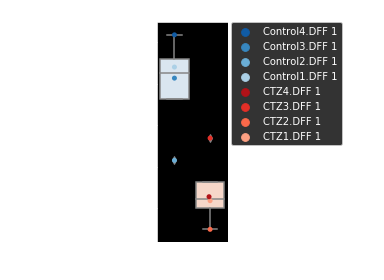

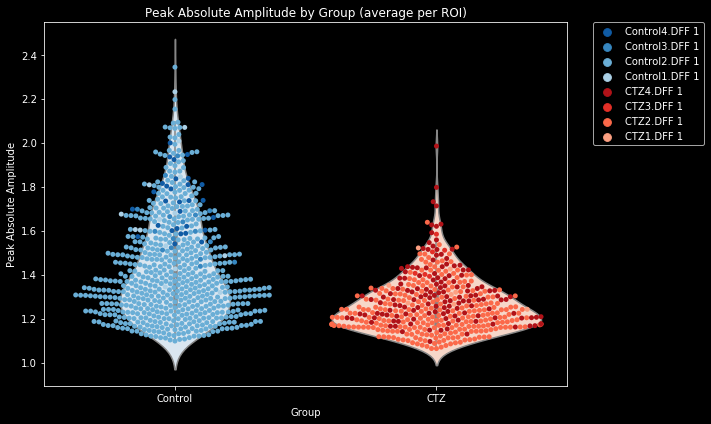

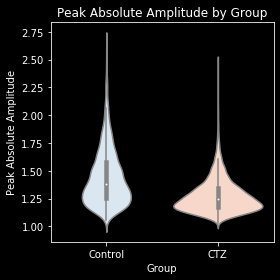

In [12]:
#Remove all experiments that have "Batch" in the name
experiments_amplitude_df = experiments_amplitude_df[~experiments_amplitude_df['experiment_id'].str.contains('Batch')]
experiments_amplitude_df['experiment_id'].unique()
experiments_amplitude_df['group'] = experiments_amplitude_df['experiment_id'].apply(lambda x: 'CTZ' if 'CTZ' in x else 'Control')

#Make a new dataframe with average values for each ROI
experiment_avg_peak_amplitudes = experiments_amplitude_df.groupby('experiment_id').agg({'peak_absolute_amplitude': 'mean', 'peak_relative_amplitude' : 'mean' }).reset_index()
experiment_avg_peak_amplitudes['group'] = experiment_avg_peak_amplitudes['experiment_id'].apply(lambda x: 'CTZ' if 'CTZ' in x else 'Control')

roi_avg_peak_amplitudes = experiments_amplitude_df.groupby(['experiment_id', 'roi_id']).agg({'peak_absolute_amplitude': 'mean', 'peak_relative_amplitude' : 'mean' }).reset_index()
roi_avg_peak_amplitudes['group'] = roi_avg_peak_amplitudes['experiment_id'].apply(lambda x: 'CTZ' if 'CTZ' in x else 'Control')

#Sort experiments_amplitude_df and experiment_avg_peak_amplitudes to make sure control conditions are first
experiments_amplitude_df = experiments_amplitude_df.sort_values(['group', 'experiment_id'], ascending=False)
experiment_avg_peak_amplitudes = experiment_avg_peak_amplitudes.sort_values(['group', 'experiment_id'], ascending=False)
roi_avg_peak_amplitudes = roi_avg_peak_amplitudes.sort_values(['group', 'experiment_id'], ascending=False)

# Create the plot
plt.figure(figsize=(4, 4))
#Make the plot dark
plt.style.use('dark_background')
# Boxplot with group colors
sns.boxplot(data=experiment_avg_peak_amplitudes, x='group', y='peak_absolute_amplitude', palette=group_palette)
# Swarmplot with experiment_id colors
sns.swarmplot(data=experiment_avg_peak_amplitudes, x='group', y='peak_absolute_amplitude', hue='experiment_id', palette=experiment_palette)
# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Labels and title
plt.xlabel('Group')
plt.ylabel('Peak Absolute Amplitude')
plt.title('Peak Absolute Amplitude by Group (average per experiment)')
# Layout and save as PDF
plt.tight_layout()
plt.savefig('Peak_Absolute_Amplitude_by_Group.pdf', format='pdf')
plt.show()


#Use seaborn to plot a violin plot of the peak relative amplitudes
plt.figure(figsize=(10, 6))
sns.violinplot(data=roi_avg_peak_amplitudes, x='group', y='peak_absolute_amplitude', palette=group_palette)
#Add swarmplot
sns.swarmplot(data=roi_avg_peak_amplitudes, x='group', y='peak_absolute_amplitude', hue='experiment_id', palette=experiment_palette)
#put legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Group')
plt.ylabel('Peak Absolute Amplitude')
plt.title('Peak Absolute Amplitude by Group (average per ROI)')
plt.tight_layout()
#Seve as pdf
plt.savefig('Peak_Absolute_Amplitude_by_ROI.pdf', format='pdf')
plt.show()

#Use seaborn to plot a violin plot of the peak relative amplitudes
plt.figure(figsize=(4, 4))
sns.violinplot(data=experiments_amplitude_df, x='group', y='peak_absolute_amplitude', palette=group_palette)
#Add swarmplot
# sns.swarmplot(data=experiments_amplitude_df, x='group', y='peak_absolute_amplitude', hue='experiment_id')
plt.xlabel('Group')
plt.ylabel('Peak Absolute Amplitude')
plt.title('Peak Absolute Amplitude by Group')
plt.tight_layout()
#Seve as pdf
plt.savefig('Peak_Absolute_Amplitude.pdf', format='pdf')
plt.show()

# Plot frequency across experimental groups

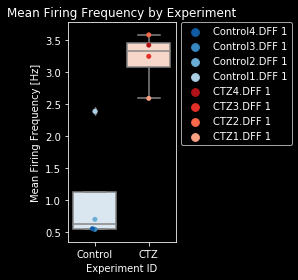

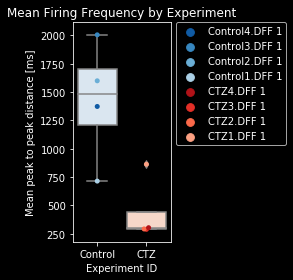

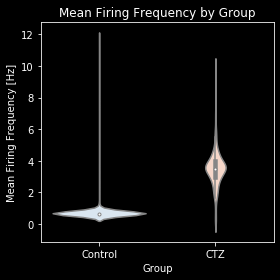

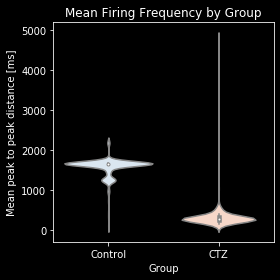

In [13]:
#Remove all experiments that have "Batch" in the name
experiments_frequency_df = experiments_frequency_df[~experiments_frequency_df['experiment_id'].str.contains('Batch')]
experiments_frequency_df['group'] = experiments_frequency_df['experiment_id'].apply(lambda x: 'CTZ' if 'CTZ' in x else 'Control')

#Make a new dataframe with average values for each experiment
experiment_avg_firing_frequency = experiments_frequency_df.groupby('experiment_id').agg({'mean_firing_frequency[Hz]': 'mean', 'mean_peak_to_peak_distance[ms]' : 'mean'}).reset_index()
experiment_avg_firing_frequency['group'] = experiment_avg_firing_frequency['experiment_id'].apply(lambda x: 'CTZ' if 'CTZ' in x else 'Control')

#Sort experiment_avg_firing_frequency and experiments_frequency_df to make sure control conditions are first
experiment_avg_firing_frequency = experiment_avg_firing_frequency.sort_values(['group', 'experiment_id'], ascending=False)
experiments_frequency_df = experiments_frequency_df.sort_values(['group', 'experiment_id'], ascending=False)

#Use seaborn to plot a boxplot of the peak absolute amplitudes
plt.figure(figsize=(4, 4))
sns.boxplot(data=experiment_avg_firing_frequency, x='group', y='mean_firing_frequency[Hz]', palette=group_palette)
#Add swarmplot
sns.swarmplot(data=experiment_avg_firing_frequency, x='group', y='mean_firing_frequency[Hz]', hue='experiment_id', palette=experiment_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Experiment ID')
plt.ylabel('Mean Firing Frequency [Hz]')
plt.title('Mean Firing Frequency by Experiment')
plt.tight_layout()
#Seve as pdf
plt.savefig('Mean_Firing_Frequency_by_Experiment.pdf', format='pdf')
plt.show()

#Use seaborn to plot a boxplot of the peak absolute amplitudes
plt.figure(figsize=(4, 4))
sns.boxplot(data=experiment_avg_firing_frequency, x='group', y='mean_peak_to_peak_distance[ms]', palette=group_palette)
#Add swarmplot
sns.swarmplot(data=experiment_avg_firing_frequency, x='group', y='mean_peak_to_peak_distance[ms]', hue='experiment_id', palette=experiment_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Experiment ID')
plt.ylabel('Mean peak to peak distance [ms]')
plt.title('Mean Firing Frequency by Experiment')
plt.tight_layout()
#Seve as pdf
plt.savefig('Mean_Peak_to_Peak_by_Experiment.pdf', format='pdf')
plt.show()

#Use seaborn to plot a violin plot of the firing frequency with individual ROIs
plt.figure(figsize=(4, 4))
sns.violinplot(data=experiments_frequency_df, x='group', y='mean_firing_frequency[Hz]', palette=group_palette)
#Add swarmplot
# sns.swarmplot(data=experiments_frequency_df, x='group', y='mean_firing_frequency[Hz]', hue='experiment_id', palette=experiment_palette)
#put legend outside the plot
plt.xlabel('Group')
plt.ylabel('Mean Firing Frequency [Hz]')
plt.title('Mean Firing Frequency by Group')
plt.tight_layout()
#Seve as pdf
plt.savefig('Mean_Firing_Frequency.pdf', format='pdf')
plt.show()

#Use seaborn to plot a violin plot of the firing frequency with individual ROIs
plt.figure(figsize=(4, 4))
sns.violinplot(data=experiments_frequency_df, x='group', y='mean_peak_to_peak_distance[ms]', palette=group_palette)
#Add swarmplot
# sns.swarmplot(data=experiments_frequency_df, x='group', y='mean_firing_frequency[Hz]', hue='experiment_id', palette=experiment_palette)
#put legend outside the plot
plt.xlabel('Group')
plt.ylabel('Mean peak to peak distance [ms]')
plt.title('Mean Firing Frequency by Group')
plt.tight_layout()
#Seve as pdf
plt.savefig('Mean_Peak_to_Peak.pdf', format='pdf')
plt.show()


# Plot synchrony plots

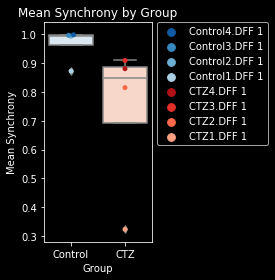

In [14]:
#Remove all experiments that have "Batch" in the name
experimets_synchrony_df = experimets_synchrony_df[~experimets_synchrony_df['experiment_id'].str.contains('Batch')]

experimets_synchrony_df['group'] = experimets_synchrony_df['experiment_id'].apply(lambda x: 'CTZ' if 'CTZ' in x else 'Control')

#sort the dataframe by group
experimets_synchrony_df = experimets_synchrony_df.sort_values(['group', 'experiment_id'], ascending=False)

#Use seaborn to plot a boxplot of the synchrony
plt.figure(figsize=(4, 4))
sns.boxplot(data=experimets_synchrony_df, x='group', y='mean_synchrony', palette=group_palette)
#Add swarmplot
sns.swarmplot(data=experimets_synchrony_df, x='group', y='mean_synchrony', hue='experiment_id', palette=experiment_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Group')
plt.ylabel('Mean Synchrony')
plt.title('Mean Synchrony by Group')
plt.tight_layout()
#Seve as pdf
plt.savefig('Mean_Synchrony_by_Group.pdf', format='pdf')
plt.show()


# Look at peak height distribution

In [ ]:
experiment_id = 'Batch124_ApoE2_FOV1.DFF'
data_path = 'data'
experiment_path = join(data_path, experiment_id)

array, df = load_data(join(data_path, experiment_id + '.txt'))
experiment_df = pd.read_csv(join(experiment_path, experiment_id + '_experiment_df.csv'))
experiment_df.head()

experiment_df['noise_level'] = experiment_df['roi_id'].apply(lambda x: calc_noise_levels(array, int(x.rsplit('ROI')[1]) - 1))
    

experiment_df.head()

,roi_id,peak_time,peak_absolute_amplitude,peak_relative_amplitude,noise_level
0,ROI1,428,1.545500,0.523404,0.010076
1,ROI1,827,1.350890,0.328794,0.010076
2,ROI1,2369,1.677700,0.655604,0.010076
3,ROI1,2598,1.086602,0.064506,0.010076
4,ROI1,2959,1.145090,0.122994,0.010076


In [19]:
#For all individual experiments, plot the noise level histogram in different colors
fig = go.Figure()
for experiment_id in experiments_amplitude_df['experiment_id'].unique():
    experiment_df_subset = experiments_amplitude_df[experiments_amplitude_df['experiment_id'] == experiment_id]
    fig.add_trace(go.Histogram(x=experiment_df_subset['noise_level'], nbinsx=50, name=experiment_id))

fig.update_layout(title='Noise Level Distribution by Experiment', xaxis_title='Noise Level', yaxis_title='Count')
#Makee the plot dark
fig.update_layout(template='plotly_dark')
#Use experiment_palette to color the histogram bars
for i, experiment_id in enumerate(experiments_amplitude_df['experiment_id'].unique()):
    fig.data[i].marker.color = experiment_palette[experiment_id]
fig.show()

#Save as html
fig.write_html('noise_level_histogram_by_experiment.html')


In [20]:
import plotly.graph_objects as go

fig = go.Figure()

# Loop through each experiment and add a normalized histogram trace
for experiment_id in experiments_amplitude_df['experiment_id'].unique():
    experiment_df_subset = experiments_amplitude_df[experiments_amplitude_df['experiment_id'] == experiment_id]
    fig.add_trace(
        go.Histogram(
            x=experiment_df_subset['noise_level'],
            nbinsx=50,
            name=experiment_id,
            histnorm='percent'  # Normalize to percentage
        )
    )

# Update layout for a dark theme and axis labels
fig.update_layout(
    title='Noise Level Distribution by Experiment',
    xaxis_title='Noise Level [dF/F]',
    yaxis_title='Percentage of ROIs',
    template='plotly_dark'
)
for i, experiment_id in enumerate(experiments_amplitude_df['experiment_id'].unique()):
    fig.data[i].marker.color = experiment_palette[experiment_id]
fig.show()
#Save as html
fig.write_html('noise_level_histogram_by_experiment_normalized.html')


In [ ]:
#Plot a histogram of the noise levels using plotly
fig = go.Figure()
fig.add_trace(go.Histogram(x=experiment_df['noise_level'], nbinsx=50))
fig.update_layout(title='Noise Level Distribution', xaxis_title='Noise Level', yaxis_title='Count')
#Makee the plot dark
fig.update_layout(template='plotly_dark')
fig.show()

In [48]:
mean_noise_level = experiment_df['noise_level'].mean()

below_mean_subset = experiment_df[experiment_df['noise_level'] < mean_noise_level]
above_mean_subset = experiment_df[experiment_df['noise_level'] >= mean_noise_level]

In [49]:
#Plot a histogram of the peak heights
fig = go.Figure()
# fig.add_trace(go.Histogram(x=experiment_df['peak_absolute_amplitude'], nbinsx=25, name='Lower noise ROIs'))
fig.add_trace(go.Histogram(x=below_mean_subset['peak_absolute_amplitude'], nbinsx=25, name='Lower noise ROIs'))
fig.add_trace(go.Histogram(x=above_mean_subset['peak_absolute_amplitude'], nbinsx=25, name='Higher noise ROIs'))
# fig.update_layout(title='Peak Heights Histogram', xaxis_title='Peak Height [dF/F]', yaxis_title='Count')
#Make the plot dark
fig.update_layout(template='plotly_dark')
# fig.write_html(os.path.join(data_output_dir, 'peak_heights_histogram.html'))
fig.write_image(os.path.join('peak_heights_histogram.pdf'), format='pdf')
fig.show()

## Highlight increase in noise with ROI id increase

In [111]:
#Plot traces 0 and 78
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 78], name='ROI 78'))
# fig.add_trace(go.Scatter(x=np.arange(array.shape[0]), y=array[:, 0], name='ROI 0'))
# fig.update_layout(title='Raw Signal Traces', xaxis_title='Time', yaxis_title='Intensity')
# fig.show()

#Now plot the same thing but so that it can be pasted onto black background
fig = go.Figure()
#Create an array for the x axis corresponding to np.arange(array.shape[0]), but in units of seconds rather than ms
x_arr = np.arange(array.shape[0]) / 100
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 78], name='ROI 79'))
fig.add_trace(go.Scatter(x=x_arr, y=array[:, 0], name='ROI 1'))
fig.update_layout(xaxis_title='Time [s]', yaxis_title='Intensity [dF/F]', plot_bgcolor='black', paper_bgcolor='black', font=dict(color='white'))
fig.show()
#Also export as html, pdf, and png
output_file_root = os.path.join(data_output_dir, 'sample_trace_plot')
fig.write_html(output_file_root + '.html')
fig.write_image(output_file_root + '.pdf', format='pdf')
fig.write_image(output_file_root + '.png', format='png')

In [46]:
plot_noise_level(array)